## EDA

In [35]:
import os
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
import hparams
import numpy as np
from utils import create_dataset
warnings.filterwarnings('ignore')

In [26]:

root_dir=os.getcwd()
root_dir

'/home/rifat/Desktop/Radiograph-Age-Prediction'

In [27]:
#loading dataframes
train_df = pd.read_csv(root_dir+'/data/Bone Age Training Set/train.csv')
df_test = pd.read_excel(root_dir+'/data/Bone Age Test Set/test.xlsx')

#appending file extension to id column for both training and testing dataframes
train_df['id'] = train_df['id'].apply(lambda x: str(x)+'.png')
df_test['Case ID'] = df_test['Case ID'].apply(lambda x: str(x)+'.png') 


train_df['img_path'] = train_df['id'].apply(lambda x: '/data/Bone Age Training Set/boneage-training-dataset/'+str(x)+'.png')
df_test['img_path'] = df_test['Case ID'].apply(lambda x: '/data/Bone Age Test Set/boneage-testing-dataset/'+str(x)+'.png') 

train_df.head()

,id,boneage,male,img_path
0,1377.png,180,False,/data/Bone Age Training Set/boneage-training-d...
1,1378.png,12,False,/data/Bone Age Training Set/boneage-training-d...
2,1379.png,94,False,/data/Bone Age Training Set/boneage-training-d...
3,1380.png,120,True,/data/Bone Age Training Set/boneage-training-d...
4,1381.png,82,False,/data/Bone Age Training Set/boneage-training-d...


male      6833
female    5778
Name: gender, dtype: int64


<AxesSubplot:xlabel='gender', ylabel='count'>

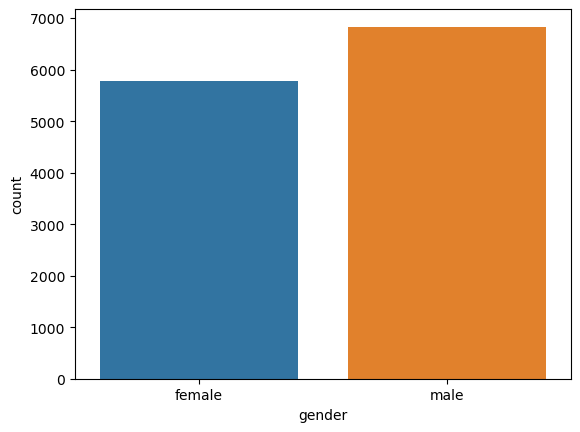

In [28]:
#finding out the number of male and female children in the dataset
#creating a new column called gender to keep the gender of the child as a string
train_df['gender'] = train_df['male'].apply(lambda x: 'male' if x else 'female')
print(train_df['gender'].value_counts())
sns.countplot(x = train_df['gender'])

In [29]:
#oldest child in the dataset
print('MAX age: ' + str(train_df['boneage'].max()) + ' months')

#youngest child in the dataset
print('MIN age: ' + str(train_df['boneage'].min()) + ' months')

#mean age is
mean_bone_age = train_df['boneage'].mean()
print('mean: ' + str(mean_bone_age))

#median bone age
print('median: ' +str(train_df['boneage'].median()))

#standard deviation of boneage
std_bone_age = train_df['boneage'].std()

#models perform better when features are normalised to have zero mean and unity standard deviation
#using z score for the training
train_df['bone_age_z'] = (train_df['boneage'] - mean_bone_age)/(std_bone_age)

print(train_df.head())

MAX age: 228 months
MIN age: 1 months
mean: 127.3207517246848
median: 132.0
         id  boneage   male  \
0  1377.png      180  False   
1  1378.png       12  False   
2  1379.png       94  False   
3  1380.png      120   True   
4  1381.png       82  False   

                                            img_path  gender  bone_age_z  
0  /data/Bone Age Training Set/boneage-training-d...  female    1.279181  
1  /data/Bone Age Training Set/boneage-training-d...  female   -2.800269  
2  /data/Bone Age Training Set/boneage-training-d...  female   -0.809109  
3  /data/Bone Age Training Set/boneage-training-d...    male   -0.177766  
4  /data/Bone Age Training Set/boneage-training-d...  female   -1.100498  


Text(0.5, 1.0, 'Number of children in each age group')

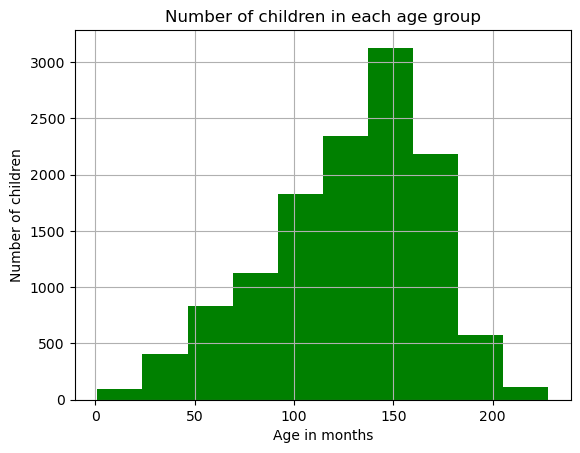

In [30]:
#plotting a histogram for bone ages
train_df['boneage'].hist(color = 'green')
plt.xlabel('Age in months')
plt.ylabel('Number of children')
plt.title('Number of children in each age group')

## Preprocess

In [39]:
x = train_df['img_path'].tolist()
y = train_df['boneage'].tolist()

In [40]:
x

['/data/Bone Age Training Set/boneage-training-dataset/1377.png.png',
 '/data/Bone Age Training Set/boneage-training-dataset/1378.png.png',
 '/data/Bone Age Training Set/boneage-training-dataset/1379.png.png',
 '/data/Bone Age Training Set/boneage-training-dataset/1380.png.png',
 '/data/Bone Age Training Set/boneage-training-dataset/1381.png.png',
 '/data/Bone Age Training Set/boneage-training-dataset/1382.png.png',
 '/data/Bone Age Training Set/boneage-training-dataset/1383.png.png',
 '/data/Bone Age Training Set/boneage-training-dataset/1384.png.png',
 '/data/Bone Age Training Set/boneage-training-dataset/1385.png.png',
 '/data/Bone Age Training Set/boneage-training-dataset/1387.png.png',
 '/data/Bone Age Training Set/boneage-training-dataset/1388.png.png',
 '/data/Bone Age Training Set/boneage-training-dataset/1389.png.png',
 '/data/Bone Age Training Set/boneage-training-dataset/1390.png.png',
 '/data/Bone Age Training Set/boneage-training-dataset/1391.png.png',
 '/data/Bone Age Tra

In [41]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

In [42]:
batch_size = hparams.BATCH_SIZE
train_dataset = create_dataset(x_train,
                               batch_size=batch_size,
                               shuffle=True,
                               cache_file='train_cache')

val_dataset = create_dataset(x_val,
                              batch_size=batch_size,
                              shuffle=False,
                              cache_file='val_cache')

train_steps = int(np.ceil(len(x_train) / batch_size))
val_steps = int(np.ceil(len(x_val) / batch_size))

2022-12-07 02:27:30.348248: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 02:27:30.403866: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 02:27:30.404104: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 02:27:30.411699: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [52]:
# FUNCTION: define a convolutional autoencoder as described above

def build_deep_autoencoder(img_shape, code_size):
    """
    Arguments:
    img_shape_x -- size of the input layer
    code_size -- the size of the hidden representation of the input (code)

    Returns:
    encoder -- keras model for the encoder network
    decoder -- keras model for the decoder network
    """

    # encoder
    ### START CODE HERE ###
    encoder = tf.keras.Sequential()
    encoder.add(tf.keras.Input(img_shape))

    encoder.add(layers.Conv2D(32, (3, 3), activation='elu', padding='same'))
    encoder.add(layers.MaxPool2D((2, 2), padding='same'))

    encoder.add(layers.Conv2D(64, (3, 3), activation='elu', padding='same'))
    encoder.add(layers.MaxPool2D((2, 2), padding='same'))

    encoder.add(layers.Conv2D(128, (3, 3), activation='elu', padding='same'))
    encoder.add(layers.MaxPool2D((2, 2), padding='same'))

    encoder.add(layers.Conv2D(256, (3, 3), activation='elu', padding='same'))
    encoder.add(layers.MaxPool2D((2, 2), padding='same'))

    encoder.add(layers.Flatten())
    encoder.add(layers.Dense(code_size))
    ### END CODE HERE ###

    # decoder
    ### START CODE HERE ###
    decoder = tf.keras.Sequential()
    decoder.add(tf.keras.Input((code_size,)))

    decoder.add(layers.Dense(6 * 6 * 256, activation='elu'))
    decoder.add(layers.Reshape((6, 6, 256)))
    decoder.add(layers.Conv2DTranspose(128, (3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(layers.Conv2DTranspose(64, (3, 3), strides=2, activation='elu', padding='valid'))
    decoder.add(layers.Conv2DTranspose(32, (3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(layers.Conv2DTranspose(3, (3, 3), strides=2, activation=None, padding='same'))
    ### END CODE HERE ###

    return encoder, decoder

AttributeError: module 'hyper_param' has no attribute 'MY_TEST'